In [2]:
import pickle
import pathlib
import collections
import community
import numpy as np
import pandas as pd
import networkx as nx

from scipy import spatial
from matplotlib import pyplot as plt

In [3]:
rel_data_folder_path = pathlib.Path("./../../data")
transport_data_path = rel_data_folder_path.joinpath('transport_data')
city_network_graphs = rel_data_folder_path.joinpath('network_graphs')

- **d(integer)**: Straight-line distance between two stops expressed in meters.
- **duration_avg(integer)**: Travel time between stops averaged over all PT vehicles rounded to one second accuracy.
- **n_vehicles(integer)**: Number of PT vehicles that have traveled between two stops within a time interval
- **route_I_counts(list (string))**: A list of route_I's and the number of times each route has operated between two stops. For the network extracts, this data is formatted as a string where each element is written as `route_I:count` and different routes are separated by a comma. An example value for this field is thus `1:3,2:131,10:93`. Please note that the definition of a route varies across the cities provided, and that routes can have deviations from their main paths for instance when traveling to and from a depot.
- **route_I(integer)**: Identifier for a route.

Below is a table extracted from the [Data Paper](https://www.nature.com/articles/sdata201889) about the types of routes.

<img src="./../../data/images/about_transport_data/route-types.png" alt="Route Types" width="60%" title="route-types">

In [4]:
def load_city_graph(city_name):
    with open(city_network_graphs.joinpath(city_name.lower() + '.gpickle'), 'rb') as f:
        city_graph = pickle.load(f)
    return city_graph

In [5]:
city_name = "venice"
city_network = load_city_graph(city_name)

In [6]:
num_nodes = city_network.number_of_nodes()
num_edges = city_network.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 1874
Number of edges: 2737


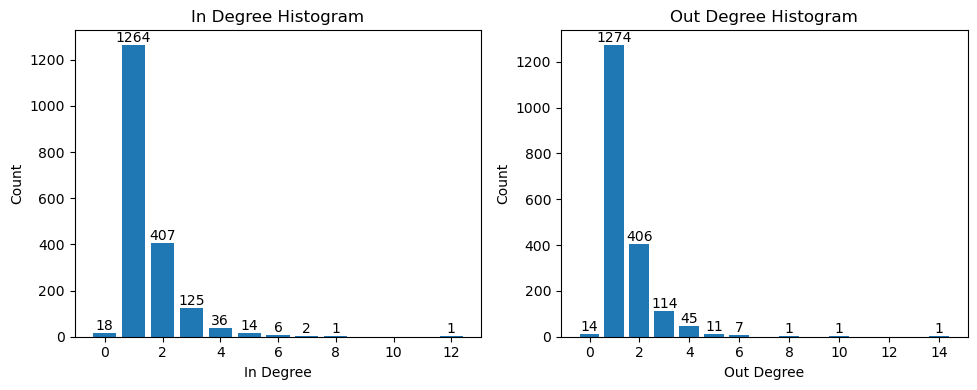

In [7]:
# node degree histogram.

in_degree_sequence = sorted([d for n, d in city_network.in_degree()], reverse=True)
in_degreeCount = collections.Counter(in_degree_sequence)
in_deg, in_count = zip(*in_degreeCount.items())


out_degree_sequence = sorted([d for n, d in city_network.out_degree()], reverse=True)
out_degreeCount = collections.Counter(out_degree_sequence)
out_deg, out_count = zip(*out_degreeCount.items())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
inbars = axes[0].bar(in_deg, in_count)
axes[0].set_title("In Degree Histogram")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("In Degree")
axes[0].bar_label(inbars)

outbars = axes[1].bar(out_deg, out_count)
axes[1].set_title("Out Degree Histogram")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Out Degree")
axes[1].bar_label(outbars)

fig.tight_layout()

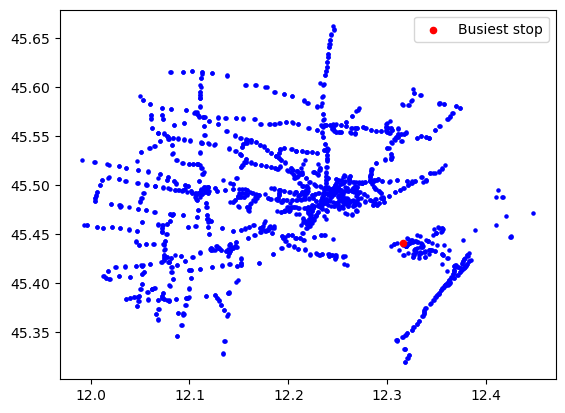

In [8]:
# Calculate the in-degree of each node, which represents the number of incoming edges
in_degree = city_network.in_degree()

# Sort the stops by the number of incoming edges in descending order
busiest_stops = sorted(in_degree, key=lambda x: x[1], reverse=True)

# Visualize the busiest stops on a map
fig, ax = plt.subplots()
for node in city_network.nodes(data=True):
    if node[0] == busiest_stops[0][0]:
        ax.scatter(node[1]['lon'], node[1]['lat'], c='red', s=20, label='Busiest stop')
    else:
        ax.scatter(node[1]['lon'], node[1]['lat'], c='blue', s=5)

ax.legend()
plt.show()

In [9]:
# Create a dataframe with the stop and number of vehicles that have traveled through it
# stop_counts = pd.DataFrame([(n, G.in_degree(n, weight='vehicle_count')) for n in G.nodes()], 
#                            columns=['stop_id', 'vehicle_count'])

# Sort the dataframe by vehicle count and select the top 10 stops

# Plot the top stops on a map
# fig = plt.figure(figsize=(8,8))
# m = Basemap(projection='merc', resolution='h', 
#             llcrnrlat=40, urcrnrlat=60,
#             llcrnrlon=10, urcrnrlon=30)

# m.drawcoastlines()
# m.fillcontinents(color='gray')
# m.drawcountries()
# m.drawmapboundary()

# for index, row in top_stops.iterrows():
#     x, y = m(row['longitude'], row['latitude'])
#     m.plot(x, y, 'ro', markersize=row['vehicle_count'], alpha=0.5)

# plt.show()

In [10]:
# Group the edges by route type and calculate the average travel time for each group
# route_types = edge_df['route_type'].unique()
# for route_type in route_types:
#     edges = [edge for edge in G.edges(data=True) if edge[2]['route_type'] == route_type]
#     average_travel_time = sum([edge[2]['weight'] for edge in edges]) / len(edges)
#     print(f"Average travel time for route type {route_type}: {average_travel_time}")

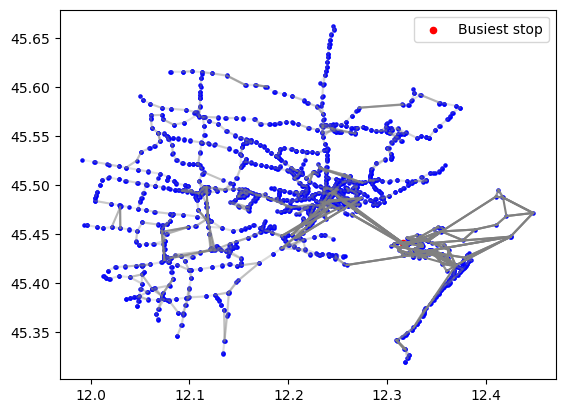

In [11]:
# Calculate the in-degree of each node, which represents the number of incoming edges
in_degree = city_network.in_degree()

# Sort the stops by the number of incoming edges in descending order
busiest_stops = sorted(in_degree, key=lambda x: x[1], reverse=True)

# Visualize the transport network on a map
fig, ax = plt.subplots()

for edge in city_network.edges(data=True):
    for node in city_network.nodes(data=True):
        if node[0] == edge[0]:
            source = node
        elif node[0] == edge[1]:
            target = node
            
    weight = edge[2]['duration_avg']
    ax.plot([source[1]['lon'], target[1]['lon']],
            [source[1]['lat'], target[1]['lat']],
            c='gray', alpha=min(weight/500, 1))

for node in city_network.nodes(data=True):
    if node[0] == busiest_stops[0][0]:
        ax.scatter(node[1]['lon'], node[1]['lat'], c='red', s=20, label='Busiest stop')
    else:
        ax.scatter(node[1]['lon'], node[1]['lat'], c='blue', s=5)    

ax.legend()    
plt.show()

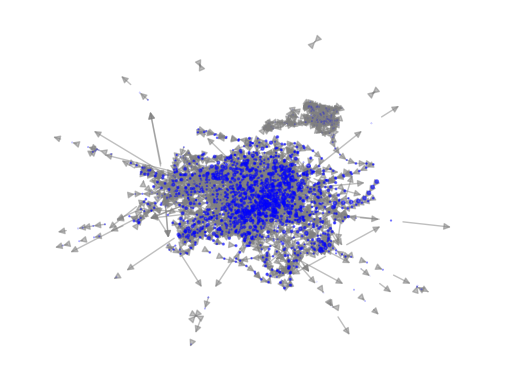

In [12]:
# Calculate the betweenness centrality of each node
betweenness = nx.betweenness_centrality(city_network, weight='duration_avg')

# Visualize the betweenness centrality of nodes
pos = nx.spring_layout(city_network)
node_sizes = [betweenness[n] * 100 for n in city_network.nodes()]
nx.draw_networkx_nodes(city_network, pos, node_size=node_sizes, node_color='blue', alpha=0.5)
nx.draw_networkx_edges(city_network, pos, edge_color='gray', alpha=0.5)
# nx.draw_networkx_labels(city_network, pos, labels=nx.get_node_attributes(city_network, 'name'), font_size=8)
plt.axis('off')
plt.show()

In [13]:
print("Network sparsity: %.4f" %nx.density(city_network))

Network sparsity: 0.0008


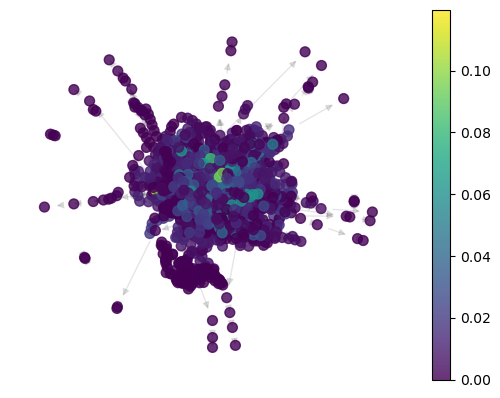

In [14]:
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(city_network, betweenness, 'betweenness')

# similar pattern
list_nodes =list(city_network.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
pos = nx.spring_layout(city_network)
ec = nx.draw_networkx_edges(city_network, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(city_network, pos, node_size=200, nodelist=list_nodes, node_color=[city_network.nodes[n]["betweenness"] for n in list_nodes], 
                            alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

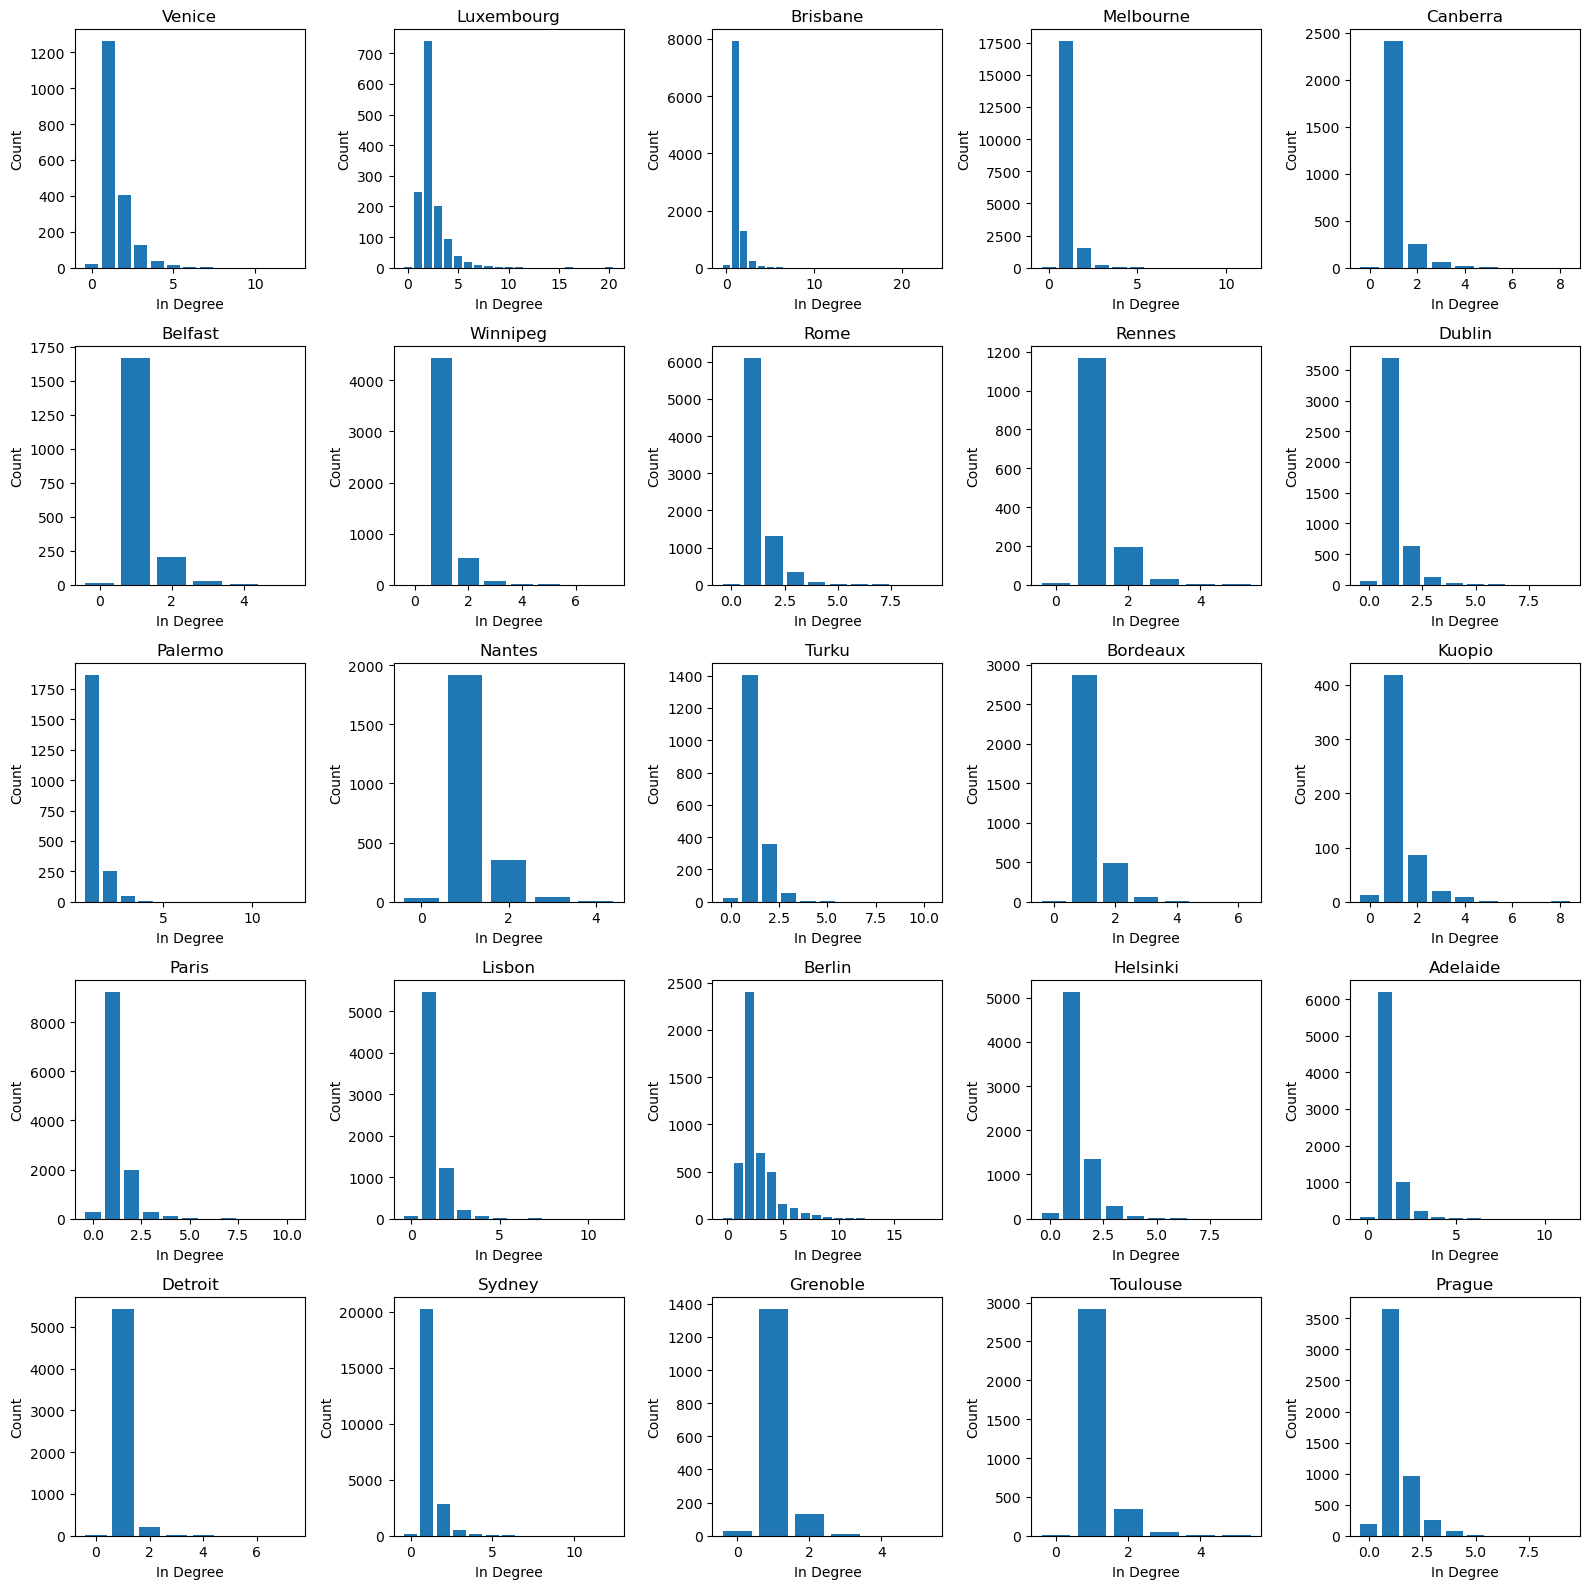

In [15]:
# In-Degree distribution of the transport network across different cities.
import os
cities = []
for name in os.listdir(city_network_graphs):
    name = name.split(".gpickle")[0]
    cities.append(name)

fig, axes = plt.subplots(5, 5, figsize=(16, 16))
for idx, city in enumerate(cities):
    # Load the graph for this city
    city_G = load_city_graph(city)
    in_degree_sequence = sorted([d for n, d in city_G.in_degree()], reverse=True)
    in_degreeCount = collections.Counter(in_degree_sequence)
    in_deg, in_count = zip(*in_degreeCount.items())

    # Plot the distribution as a bar graph
    row = int(idx / 5)
    col = idx % 5

    inbars = axes[row][col].bar(in_deg, in_count)
    axes[row][col].set_title(city.title())
    axes[row][col].set_ylabel("Count")
    axes[row][col].set_xlabel("In Degree")
fig.tight_layout()
    

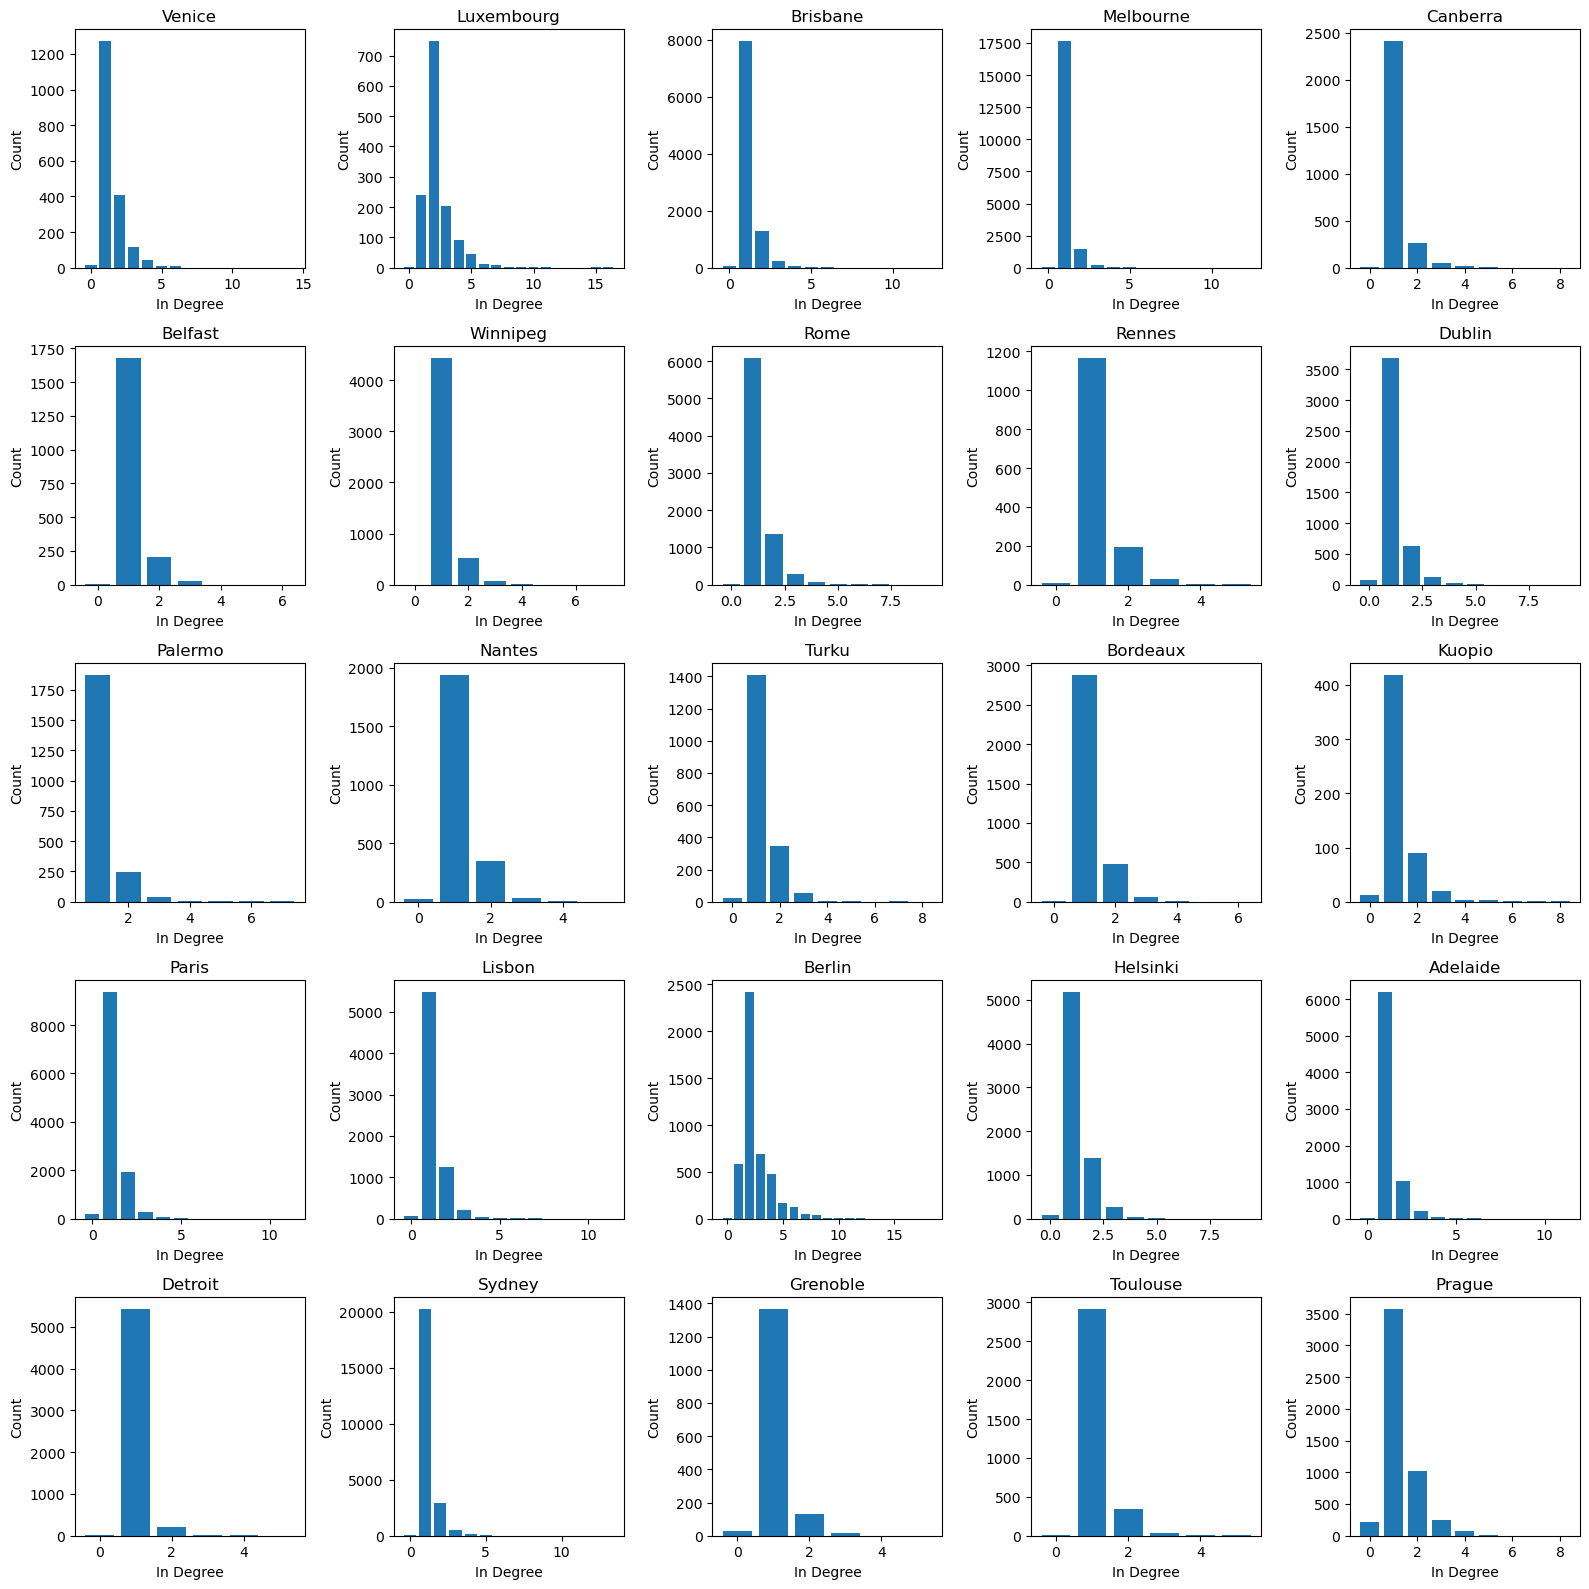

In [ ]:
# Out-Degree distribution of the transport network across different cities.
import os
cities = []
for name in os.listdir(city_network_graphs):
    name = name.split(".gpickle")[0]
    cities.append(name)

fig, axes = plt.subplots(5, 5, figsize=(16, 16))
for idx, city in enumerate(cities):
    # Load the graph for this city
    city_G = load_city_graph(city)
    out_degree_sequence = sorted([d for n, d in city_G.out_degree()], reverse=True)
    out_degree_count = collections.Counter(out_degree_sequence)
    out_deg, out_count = zip(*out_degree_count.items())

    # Plot the distribution as a bar graph
    row = int(idx / 5)
    col = idx % 5

    inbars = axes[row][col].bar(out_deg, out_count)
    axes[row][col].set_title(city.title())
    axes[row][col].set_ylabel("Count")
    axes[row][col].set_xlabel("In Degree")

fig.tight_layout()

In the above two plots, we observe that for all the cities in the dataset the in-degree distribution follows a very similar pattern to the out-degree distribution of graph nodes.
This degree distribution captures connections between two places in a city through any type of public transportation that is available in the city.

### Network properties

In the degree distribution of the city networks, the existence of a large number of nodes with low degrees and a smaller number of nodes with higher degrees is observed. This implies that the above networks cannot be modelled by a random network model.


In [51]:
def get_route_subgraph(city_network, route_type, rm_self_loop=False, rm_parallel_edges=False, tolerance=0.01):
    """
    Extracts the subgraph of the graph of a city network for a particular type
    of public transportation under consideration.

    Args:
        city_network: nx.MultiDiGraph -> network representing a city network with all transport types included.
        route_type: int -> type of transportation to compute the subgraph for
        rm_self_loops: bool -> remove self loops in the resulting subgraph
        rm_parallel_edges: bool -> remove parallel edges in the resulting subgraph
        tolerance: float -> remove self loops / parallel edges if it's percentage is within tolerance level.

    Returns:
        route_subgraph: nx.DiGraph() -> Subgraph for the specified route_type
    """
    edge_subset = []
    route_subgraph = nx.DiGraph()
    edge_attr = {}
    # Get the subset of all edges that belong to the specified route_type
    for edge in city_network.edges:
        presence_of_route = 0
        for key in city_network[edge[0]][edge[1]]:
            if city_network[edge[0]][edge[1]][key]['route_type'] == route_type:
                edge_attr = city_network[edge[0]][edge[1]][key]
                presence_of_route += 1
        if presence_of_route > 0:
            edge_subset.append((edge[0], edge[1], edge_attr))
        if presence_of_route > 1:
            print("[WARN] Many parallel edges even for this particular route_type: {}".format(route_type))
 
    route_subgraph.add_edges_from(edge_subset)

    # If the transport type doesn't exist in the city_network, ignore
    if len(route_subgraph.edges) == 0:
        return route_subgraph
    
    # Check for self loops and parallel edges in the subgraph
    self_loop_edges = []
    parallel_edges = []

    num_parallel_edges = 0
    to_change = False

    edge_list = list(route_subgraph.edges)
    edges_visited = {}

    for edge in edge_list:
        if edge[0] == edge[1]:
            self_loop_edges.append(edge)

        if edge in edges_visited:
            parallel_edges.append(edge)
            edges_visited[edge] += 1
        else:
            edges_visited[edge] = 1

    if rm_self_loop:
        # Remove any self loops in the subgraph if within tolerance percentage
        if len(self_loop_edges) <= len(route_subgraph.nodes) * tolerance:
            for edge in self_loop_edges:
                edge_list.remove(edge)
            
            if len(self_loop_edges) > 1:
                to_change = True

        else:
            print("Cannot remove self loops, as there are many")

    if rm_parallel_edges:
        # Remove parallel edges in the subgraph if within tolerance percentage.
        num_parallel_edges = 0
        edge_s = set([(edge[0], edge[1]) for edge in parallel_edges])
        for node_pair in edge_s:
            num_parallel_edges += (edges_visited[edge] - 1)

        if num_parallel_edges <= len(edge_list) * tolerance:
            for edge in parallel_edges:
                edge_list.remove(edge)
            
            if num_parallel_edges > 0:
                to_change = True
        else:
            print("Cannot remove parallel edges, as there are many {} / {}".format(len(parallel_edges), len(route_subgraph.edges)))
    
    if to_change:
        # Modify the subgraph by removing the detected self loops and / or parallel edges
        print("Removed {} self loops and {} parallel edges from the subgraph".format(len(self_loop_edges), num_parallel_edges))
        route_subgraph = route_subgraph.edge_subgraph(edge_list)

        # Test if the self loops and parallel edges are now removed
        for edge in route_subgraph.edges:
            if edge[0] == edge[1]:
                print("self loop detected!")
                break

            if route_subgraph.number_of_edges(edge[0], edge[1]) > 1:
                print("parallel edge detected!")
                break

    return route_subgraph

Removed 13 self loops and 0 parallel edges from the subgraph
Removed 3 self loops and 0 parallel edges from the subgraph
Removed 2 self loops and 0 parallel edges from the subgraph
Removed 5 self loops and 0 parallel edges from the subgraph


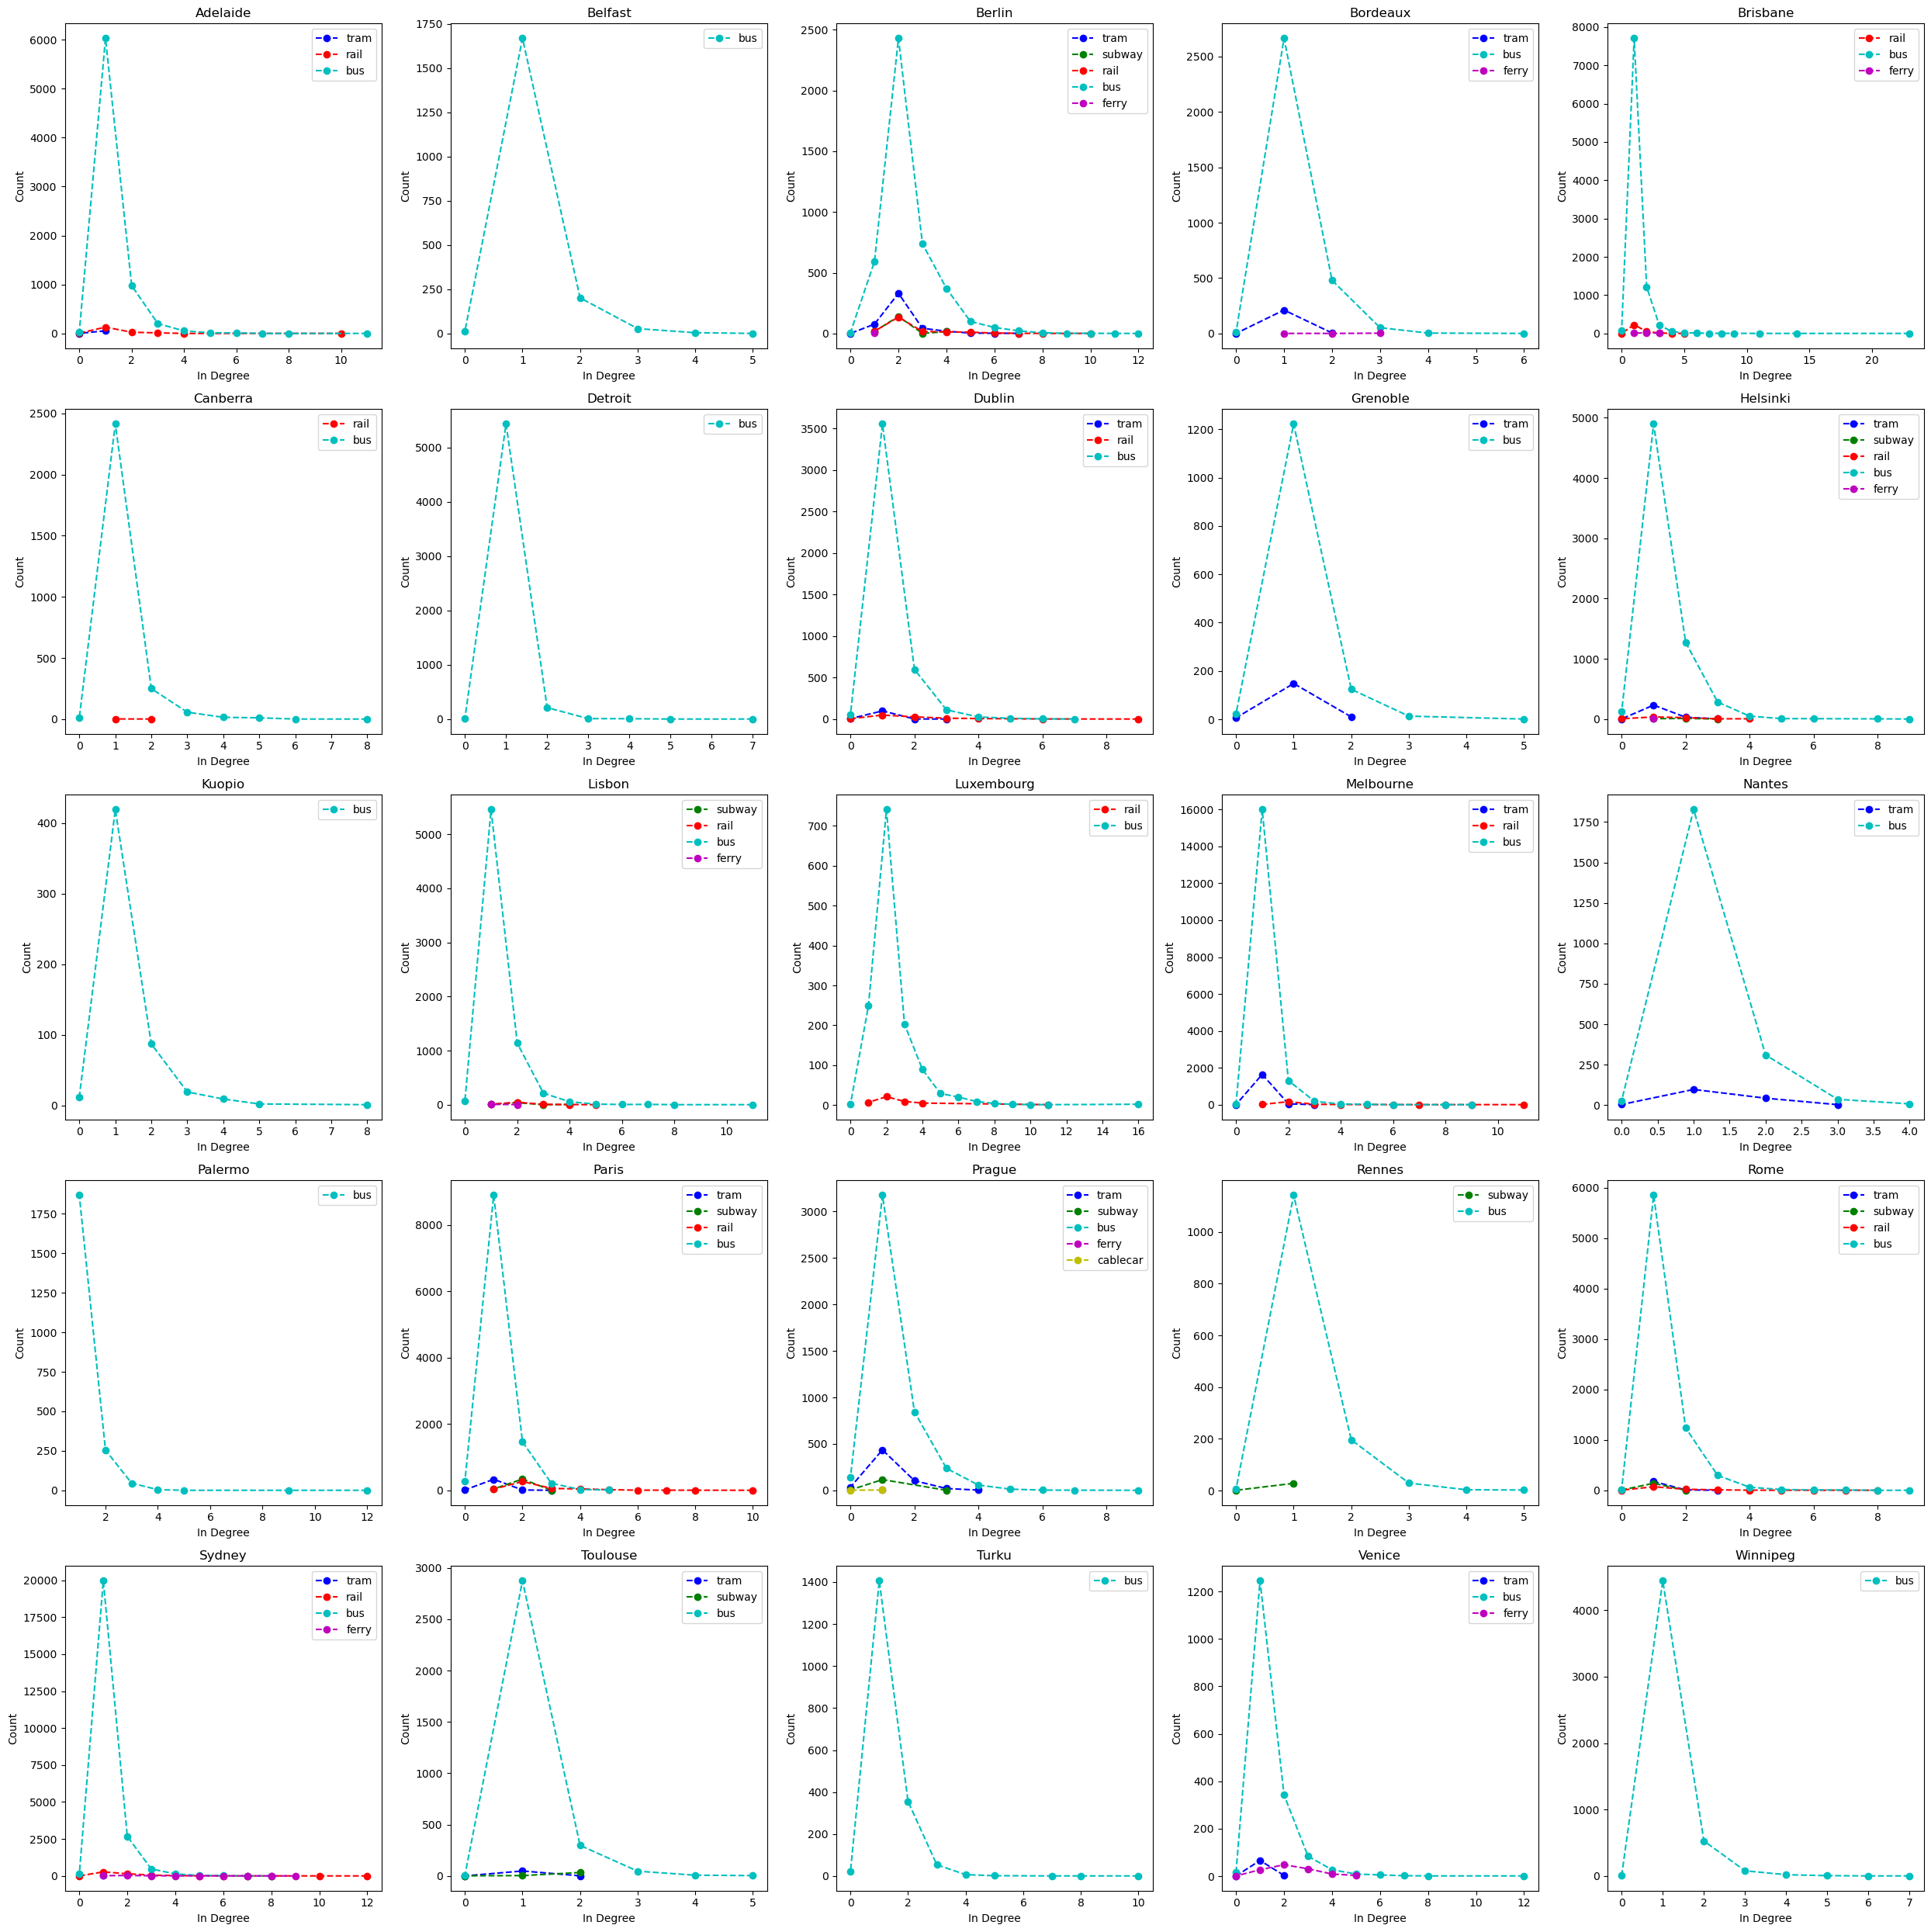

In [18]:
# In-Degree distribution of the transport network across different cities
# grouped by the various modes of transport

import os
cities = []
for name in os.listdir(city_network_graphs):
    name = name.split(".gpickle")[0]
    cities.append(name)

fig, axes = plt.subplots(5, 5, figsize=(25, 25))
route_labels = ["tram", "subway", "rail", "bus", "ferry", "cablecar", "gondola", "funicular"]
for idx, city in enumerate(sorted(cities)):
    # Load the graph for this city
    city_G = load_city_graph(city)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    # Split the degree plots into a 2-d grid
    row = int(idx / 5)
    col = idx % 5

    axes[row][col].set_title(city.title())
    axes[row][col].set_ylabel("Count")
    axes[row][col].set_xlabel("In Degree")
    for route_idx, route_label in enumerate(route_labels):
        # Get subgraph of the network for a specific route type
        route_subgraph = get_route_subgraph(city_G, route_idx, rm_self_loop=True, rm_parallel_edges=True)

        # If the subgraph of the network has no edges, ignore
        if len(route_subgraph.edges()) == 0:
            continue

        in_degree_sequence = sorted([d for n, d in route_subgraph.in_degree()], reverse=True)
        in_degreeCount = collections.Counter(in_degree_sequence)
        in_deg, in_count = zip(*in_degreeCount.items())

        # Plot the degree distribution as a line graph
        axes[row][col].plot(in_deg, in_count, color=colors[route_idx], label=route_label, linestyle='--', marker='o')

    axes[row][col].legend()
#fig.text(0.5, 0.04, 'In Degree', ha='center')
# fig.text(0.04, 0.5, 'Count', va='center', rotation='vertiscal')
fig.tight_layout()

Removed 13 self loops and 0 parallel edges from the subgraph
Removed 3 self loops and 0 parallel edges from the subgraph
Removed 2 self loops and 0 parallel edges from the subgraph
Removed 5 self loops and 0 parallel edges from the subgraph


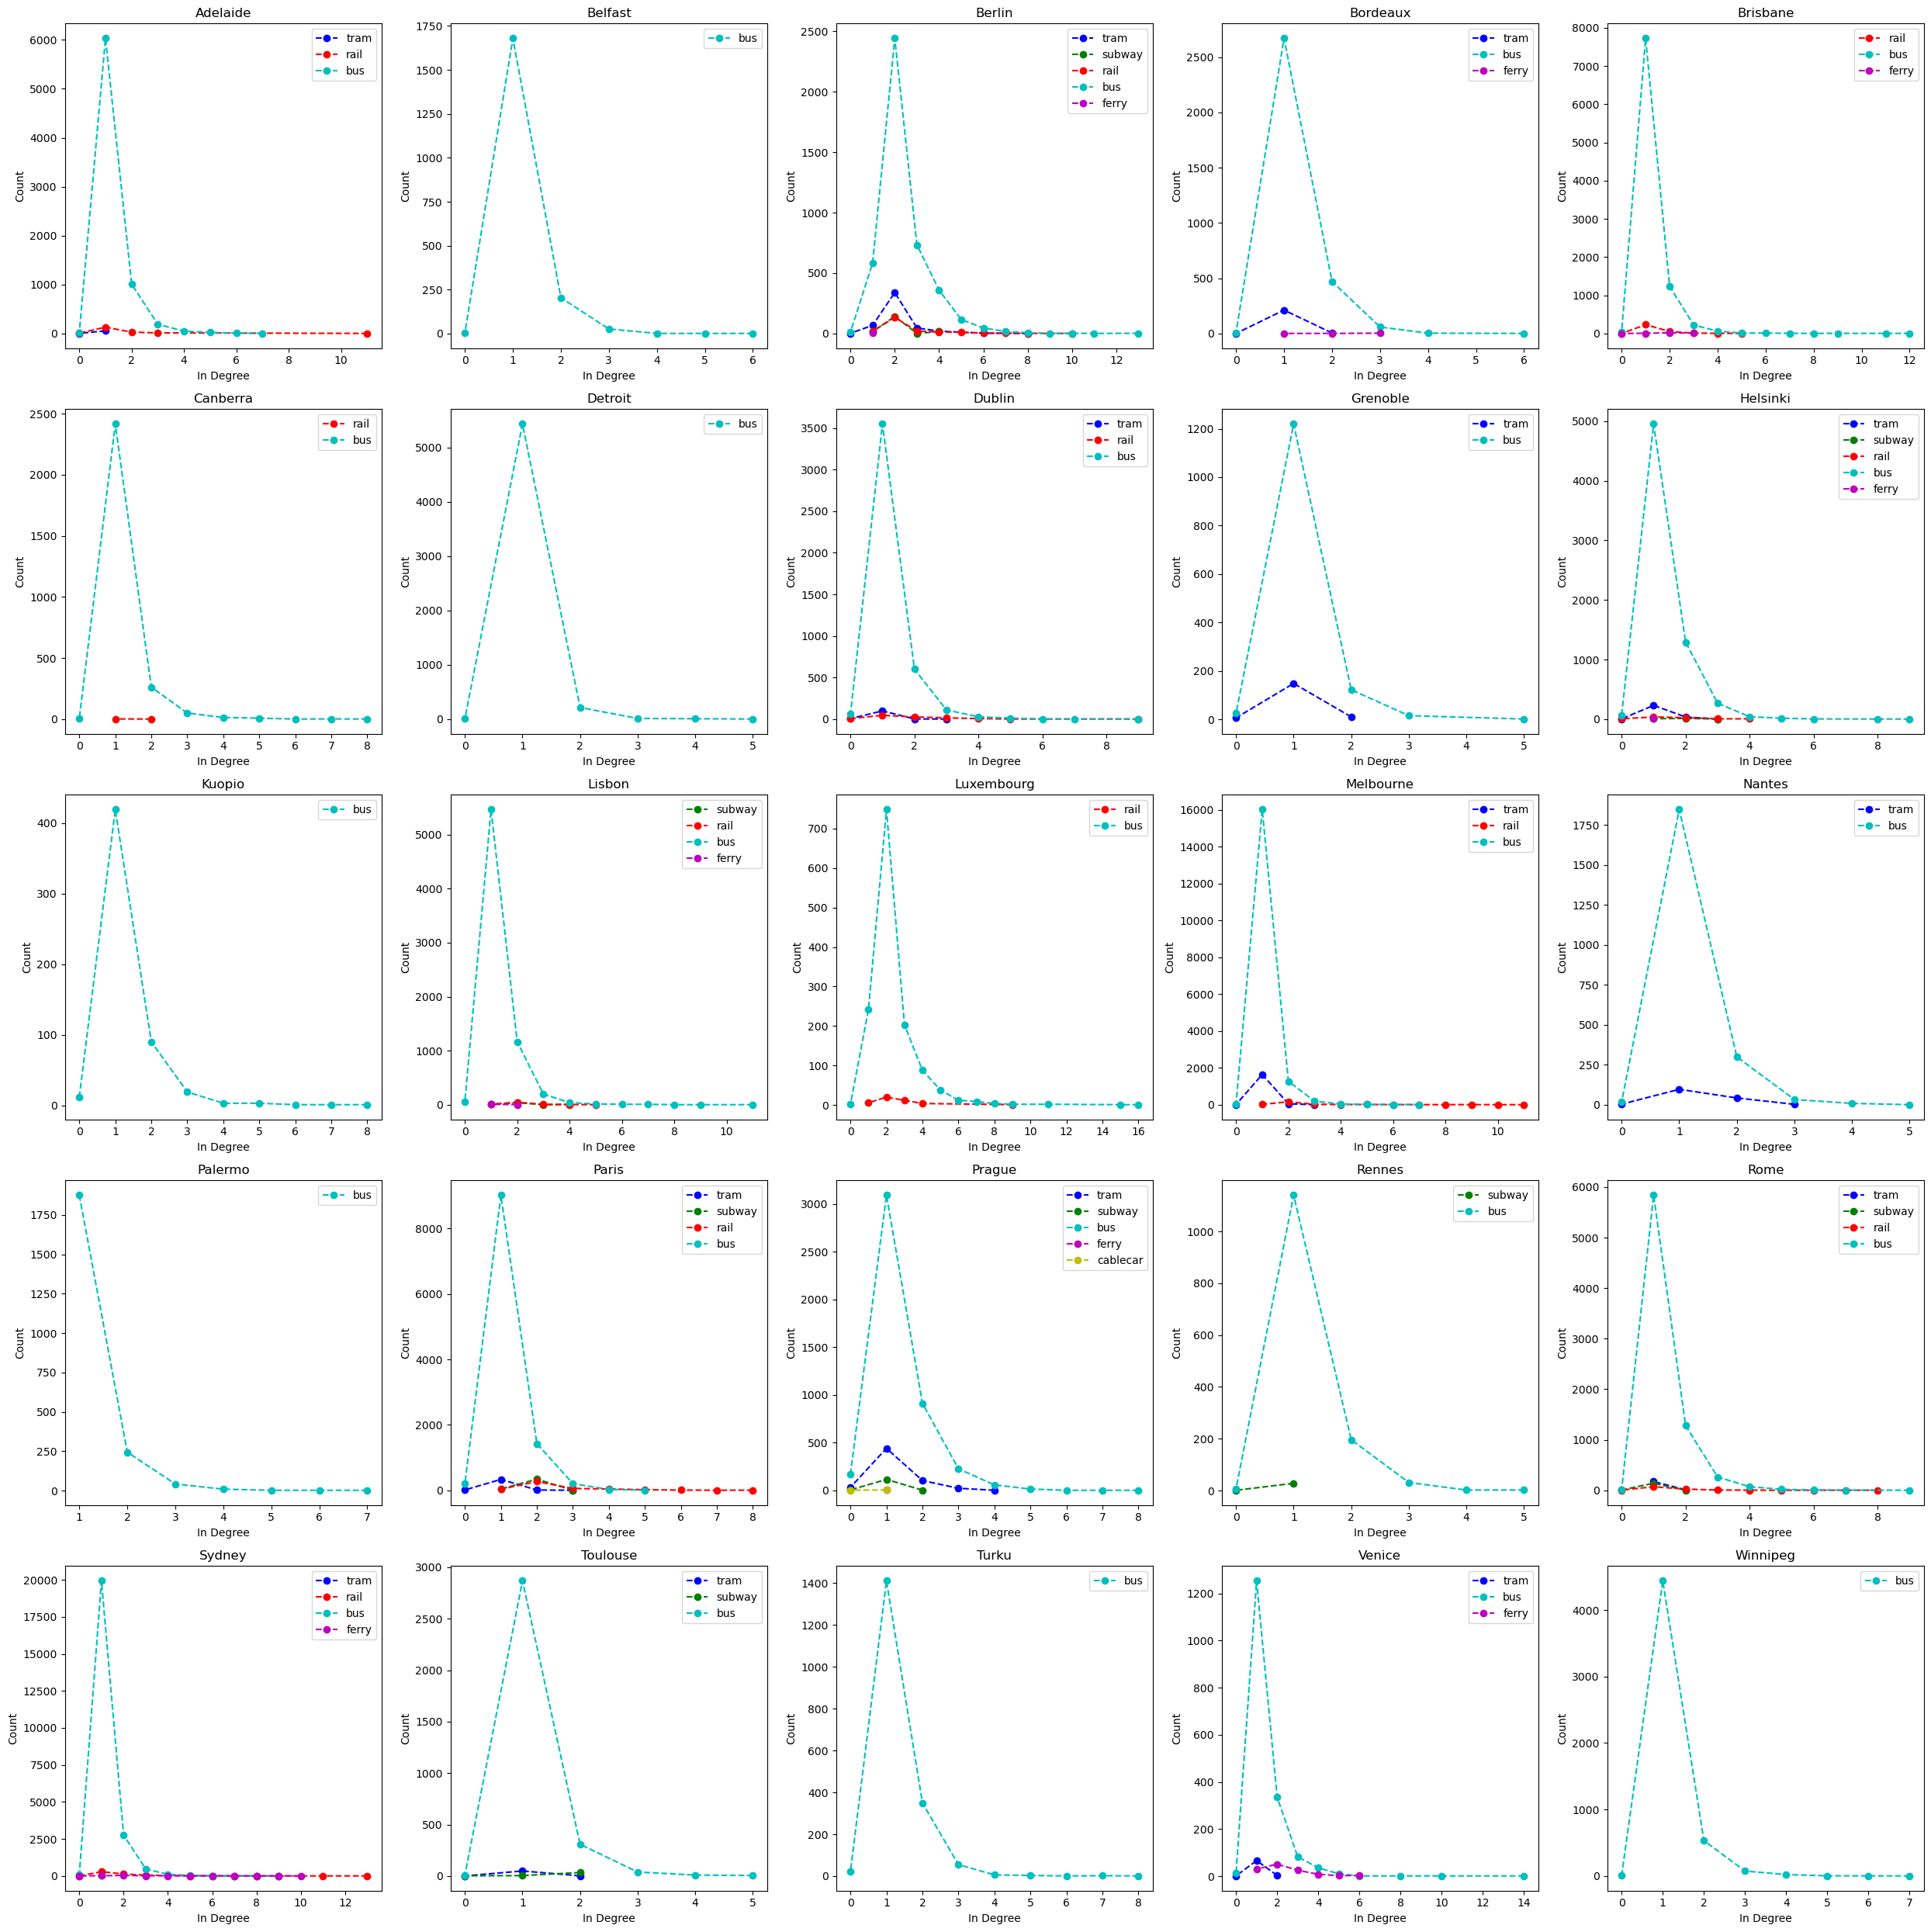

In [19]:
# Out-Degree distribution of the transport network across different cities
# groped by each different mode of transport

import os
cities = []
for name in os.listdir(city_network_graphs):
    name = name.split(".gpickle")[0]
    cities.append(name)

fig, axes = plt.subplots(5, 5, figsize=(25, 25))
route_labels = ["tram", "subway", "rail", "bus", "ferry", "cablecar", "gondola", "funicular"]
for idx, city in enumerate(sorted(cities)):
    # Load the graph for this city
    city_G = load_city_graph(city)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    # Split the degree plots into a 2-d grid
    row = int(idx / 5)
    col = idx % 5

    axes[row][col].set_title(city.title())
    axes[row][col].set_ylabel("Count")
    axes[row][col].set_xlabel("In Degree")
    for route_idx, route_label in enumerate(route_labels):
        # Get subgraph of the network for a specific route type
        route_subgraph = get_route_subgraph(city_G, route_idx, rm_self_loop=True, rm_parallel_edges=True)

        # If the subgraph of the network has no edges, ignore
        if len(route_subgraph.edges()) == 0:
            continue

        out_degree_sequence = sorted([d for n, d in route_subgraph.out_degree()], reverse=True)
        out_degree_count = collections.Counter(out_degree_sequence)
        out_deg, out_count = zip(*out_degree_count.items())

        # Plot the degree distribution as a line graph
        axes[row][col].plot(out_deg, out_count, color=colors[route_idx], label=route_label, linestyle='--', marker='o')

    axes[row][col].legend()
fig.tight_layout()

In the above two plots, we observe that for all the cities in the dataset the in-degree distribution follows a very similar pattern to the out-degree distribution of graph nodes, even when the same mode of transport is considered. As a result, it would be safe to assume either the in-degree or the out-degree of the nodes in transport network of any city as the degree of the node in our network. We would hence be considering the dataset graph to be an unirected graph with either of the in-degrees or out-degrees of the original graph as the equivalent undirected graph's degree, for further analysis from here onwards. 

It also implies that in these transport networks, the most types of public transportation listed in the dataset provide a two-way connectivity between any two places in the city.

In [20]:
# Constructing the equivalent undirected graph for the city networks
city_networks = {}
for idx, city in enumerate(cities):
    city_networks[city] = dict()
    city_G = load_city_graph(city)

    # Convert the combined graph (MulitDiGraph) into MultiGraph
    city_networks[city]["combined"] = city_G.to_undirected()

    # Consider subgraphs corresponding to each route-type (DiGraph) as Graph (undirected)
    for route_idx, route_label in enumerate(route_labels):
        route_subgraph = get_route_subgraph(city_G, route_idx, rm_self_loop=True, rm_parallel_edges=True)
        if len(route_subgraph.edges) == 0:
            continue
        
        route_subgraph_undirected = route_subgraph.to_undirected()
        city_networks[city][route_label] = route_subgraph_undirected

Removed 3 self loops and 0 parallel edges from the subgraph
Removed 2 self loops and 0 parallel edges from the subgraph
Removed 13 self loops and 0 parallel edges from the subgraph
Removed 5 self loops and 0 parallel edges from the subgraph


Text(0.5, 0.98, 'Route Types (0 : tram)    (1 : subway)    (2 : rail)    (3 : bus)    (4 : ferry)    (5 : cablecar)    (6 : gondola)    (7 : funicular)    ')

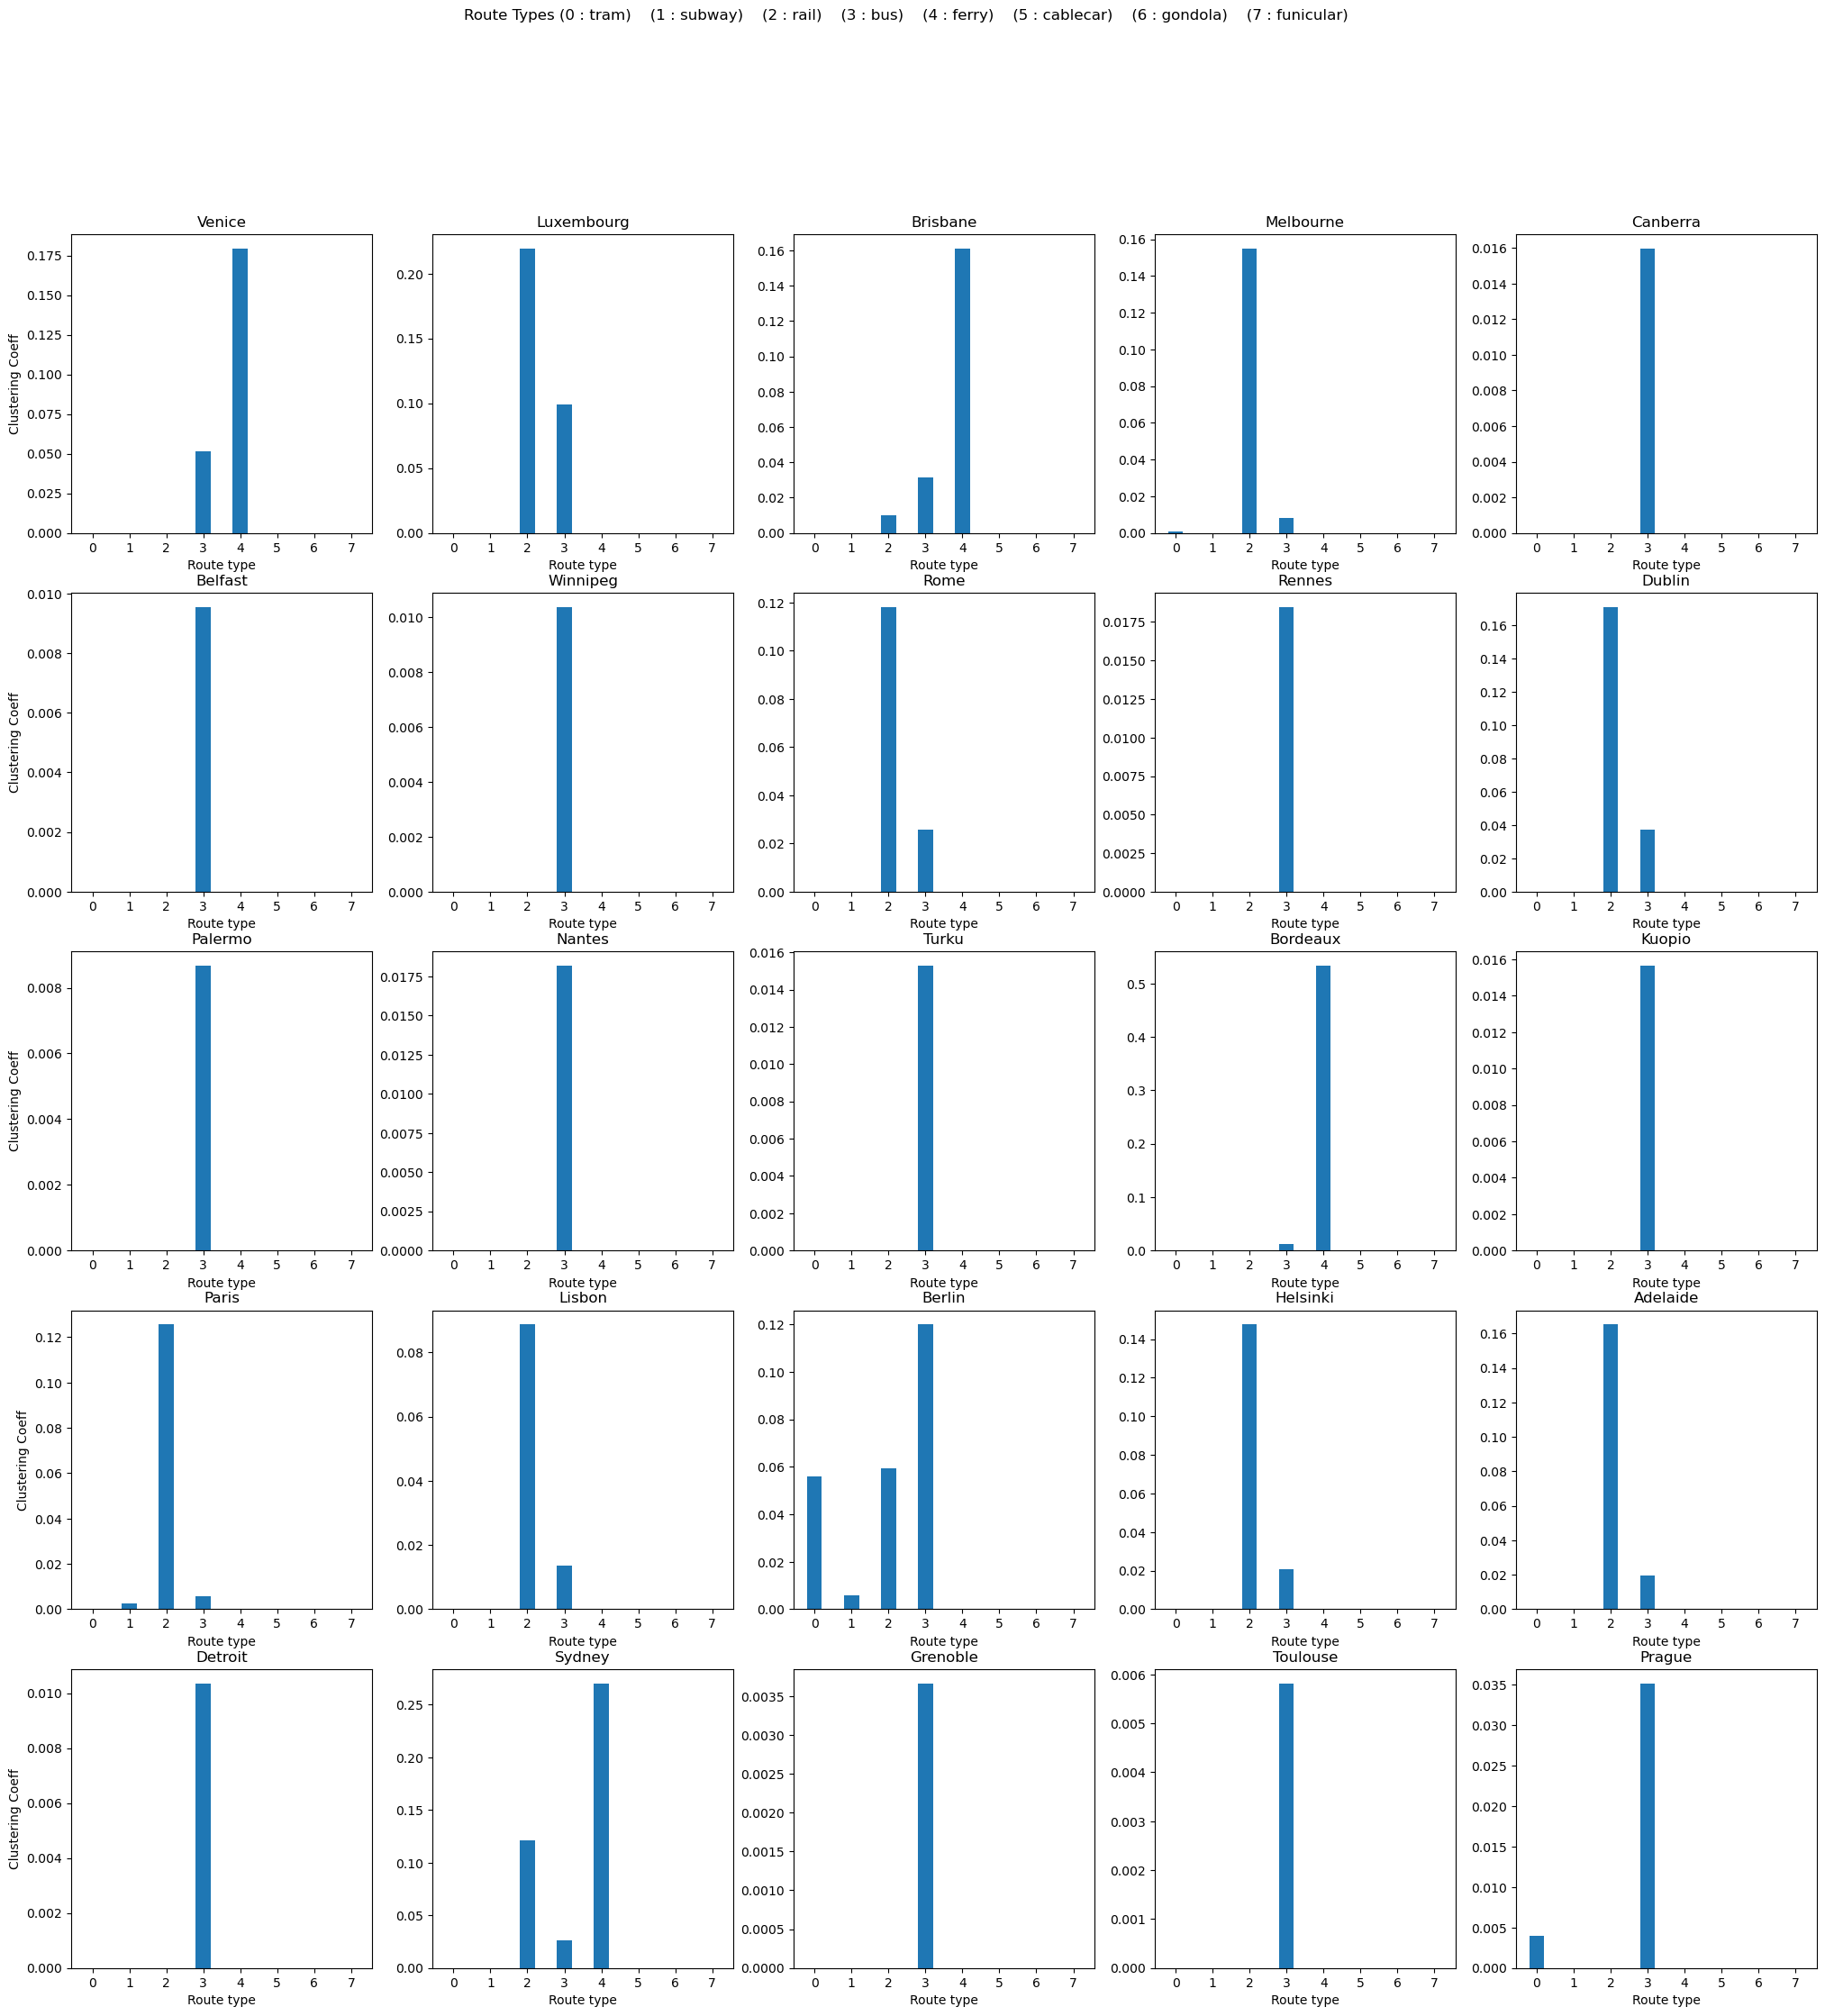

In [21]:
# Clustering coefficients across different cities, across different transport types
fig, axes = plt.subplots(5, 5, figsize=(25, 25))
for idx, city in enumerate(cities):
    clustering_coeffs = []
    for route_idx, route_label in enumerate(route_labels):
        if route_label in city_networks[city]:
            clustering_coeffs.append(nx.average_clustering(city_networks[city][route_label]))
        else:
            clustering_coeffs.append(0)

    row = int(idx / 5)
    col = idx % 5

    axes[row][col].bar(np.arange(len(route_labels)), clustering_coeffs, width=0.4)
    axes[row][col].set_xticks(np.arange(len(route_labels)))
    axes[row][col].set_xticklabels(np.arange(len(route_labels)))
    axes[row][col].set_title(city.title())
    if col == 0:
        axes[row][col].set_ylabel("Clustering Coeff")
    axes[row][col].set_xlabel("Route type")
route_description = ""
for route_idx, route_label in enumerate(route_labels):
    route_description = route_description + "({} : {})    ".format(route_idx, route_label)
fig.suptitle("Route Types {}".format(route_description))

From the above graphs, it is observed that cities with higher number of nodes and edges also posses a high clustering coefficient value in one or few of the modes of transport that it has.
This is observed for larger cities, for instance Paris, Sydney, and Berlin where the clustering coefficient of the city's popular mode of transport is `> 0.1`, whereas in cities with lesser number of nodes and edges like Prague or Canberra, have a lower clustering coefficient `< 0.04` even for it's most popular / connected mode of transport.

It is also observed that most cities have one (or rarely two) modes of transport with high clustering coefficient.

### Modeling city networks as a generation process

Looking at the degree distribution above, we concluded that it cannot be modelled by a random network model. Let us try modeling this network as a growth and / or preferential attachment based process using the Barabasi-Albert (BA) model to start with.

The BA model typically starts with an initial set of nodes $m0$ and makes use of both growth and preferential attachment in developing the network.

At each iteration in the process,
Growth: Add a new node with $m <= m0$ links that connects to `m` nodes in the existing network.
Preferential Attachment: The new nodes are attached to existing nodes in the network with the probabilities weighted according to the perferential attachment parameter $\pi_{k_{i}}$ which is defined by:
$\pi_{k_{i}} = \frac{k_{i}}{\sum\limits_{j=1}^{N}k_{j}}$
Where $\pi_{k_{i}}$ denotes the probability that a new node will get attached to node 'i' via an edge.

For the choice of the hyperparameter `m`, we make use of this expression

`[To-do: Review if it's the right choice]`
$m = \frac{\Sigma_{i=1}^N degree_{i}}{N}$

where `N` is the number of nodes

Let us consider modelling the two cities, Paris and Sydney with a large number of nodes and edges with the BA model first.

In [22]:
def compare_with_BA_model(city_G, city_name, m0=10):
    """
    Simulate a Barabasi-Albert network to model the city network
    and compare it with the original city_network's properties

    Args:
        city_G: nx.MultiDiGraph -> Network for a city
        city_name: str -> Name of the city to consider
        m0: int -> Initial number of nodes to have in the network generation process
    """
    # Degree distribution of the city network
    degrees_G = np.array([city_G.degree(node) for node in city_G.nodes()])
    m = round(sum(degrees_G)/len(degrees_G))
    
    # Barabasi Albert graph
    model_G = nx.barabasi_albert_graph(len(city_G.nodes), m)
    degrees_ba_model = np.array([model_G.degree(node) for node in model_G.nodes()])
    
    # Plot degree distributions of both networks for comparison
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].set_title("{}: City network degrees".format(city_name))
    axes[0].hist(degrees_G, bins=np.arange(np.max(degrees_G)))
    axes[1].set_title("BA model degrees")
    axes[1].hist(degrees_ba_model, bins=np.arange(np.max(degrees_G)))

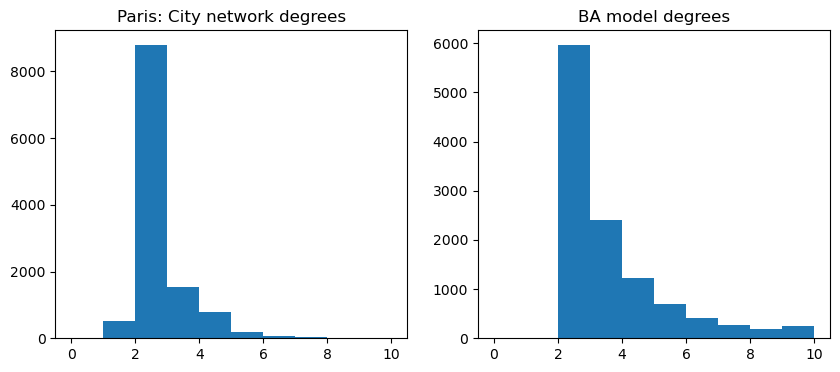

In [23]:
city_name = "Paris"
city_G = city_networks[city_name.lower()]['combined']
compare_with_BA_model(city_G=city_G, city_name=city_name, m0=10)

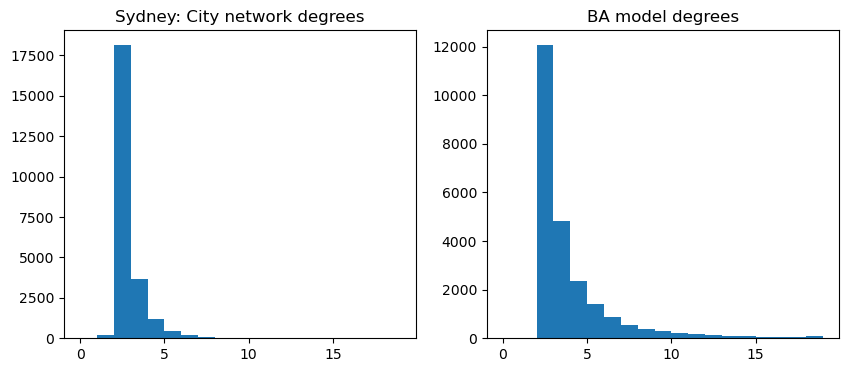

In [24]:
# Comparison for another city: Sydney
city_name = "Sydney"
city_G = city_networks[city_name.lower()]['combined']
compare_with_BA_model(city_G=city_G, city_name=city_name, m0=10)

Next, we consider modeling two cities with lesser number of nodes and edges with the network generation model.
The cities Prague and Winnipeg are considered here.

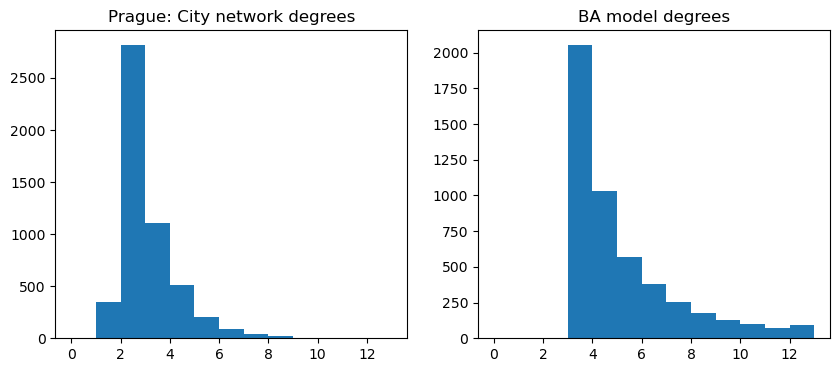

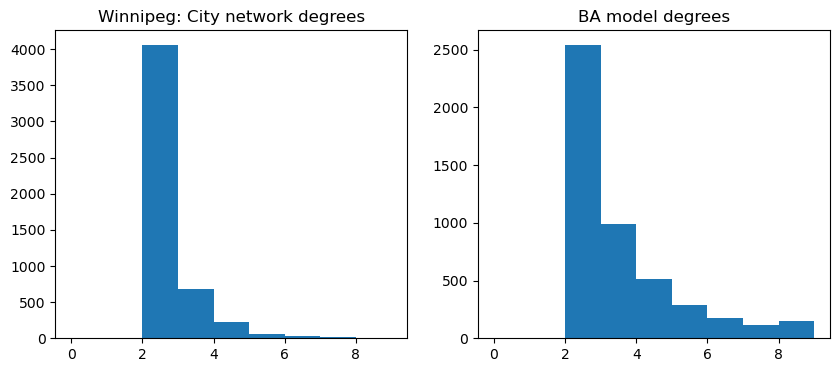

In [25]:
# Comparision for the BA model with cities Prague and Winnipeg.
city_name = "Prague"
city_G = city_networks[city_name.lower()]['combined']
compare_with_BA_model(city_G=city_G, city_name=city_name, m0=10)

city_name = "Winnipeg"
city_G = city_networks[city_name.lower()]['combined']
compare_with_BA_model(city_G=city_G, city_name=city_name, m0=10)

For all the cities considered above, we observe that the Barabasi Albert model provides a reasonably good approximation to model the nature of degree distritbutions of the nodes in the network. For cities with large number of nodes and edges, like Paris and Sydney, there is a steeper reduction in the number of nodes with the increase in the node degree and in smaller cities like Pargue and Winnipeg, the reduction is more gradual. It is possible that transport network for larger cities (in terms of nodes / edges) have higher preferential attachment factor that is superlinear in terms of node degree. The BA-model which applies a linear preferential attachment has a less steeper reduction in the number of nodes for higher degrees. It is fair to reason that city transport networks can be modelled as a generation process considering both growth and superlinear attachment features.

In [26]:
# Betweenness centrality metric
# Uncomment to run this again, it's a computationally expensive operation. The betweenness centrality values are calculated
# and dumped into the folder data/checkpoints/betweenness.pickle
# betweenness_centralities = []
# for idx, city in enumerate(cities):
#     print("[DEBUG] Calculating betweenness centrality for city {}".format(city))
#     city_G = load_city_graph(city)
#     betweenness_centralities.append(nx.betweenness_centrality(city_G))

#plt.bar(np.arange(len(cities)), betweenness_centralities, tick_label=cities)

# Save the betweenness centrality as it's a computationally expensive operation
# with open(os.path.join(rel_data_folder_path.joinpath("checkpoints"), "betweenness.pickle"), 'wb') as ckpt_file:
#    pickle.dump(betweenness_centralities, ckpt_file, pickle.HIGHEST_PROTOCOL)

In [27]:
# Betweenness centrality features
with open(os.path.join(rel_data_folder_path.joinpath("checkpoints"), "betweenness.pickle"), 'rb') as restore_file:
    betweenness_centralities = pickle.load(restore_file)

In [28]:
# Extract node-level features
# Consider hand-crafted features first
feature_names = ["degree", "betweenness", "closeness", "eigenvector"]
def node_feature_extraction(graph):
    # compute node degrees
    degree_dict = dict(graph.degree())
    # Compute node betweenness centrality
    betweenness_dict = nx.betweenness_centrality(graph)
    # Compute closeness centrality
    closeness_dict = nx.closeness_centrality(graph)
    # Compute eigenvector centrality
    eigenvector_dict = nx.eigenvector_centrality(graph)
    # Compute clustering coefficient
    clustering_dict = nx.clustering(graph)

    # Combine the hand-crafted features into a single array
    features = np.array([[degree_dict[node], betweenness_dict[node], closeness_dict[node] , eigenvector_dict[node], clustering_dict[node]] for node in graph.nodes()])

    return features

In [29]:
# Install node2vec dependencies
from IPython.display import clear_output 
!pip install node2vec
!pip install sklearn
clear_output()

In [30]:
from node2vec import Node2Vec
# Node2Vec feature extraction function
def Node2Vec_node_feature_extraction(G, num_features=1, p=1.0, q=1.0, seed=0):
  """
  Extract the node2vec features from the graph
  
  Args:
    G: nx.Graph -> Graph input
    num_features: int -> dimensions of the node embeddings
    p: float -> return parameter, explains the likelihood of immediately revisiting a particular node
    q: float -> in-out parameter, allows search to differentiate between "inward" and "outward" nodes
    seed: please always set to 0
  
  Returns:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: dimension of Node2Vec embeddings) 
  """
  
  node2vec_ = Node2Vec(G, dimensions=num_features, p=p, q=q, seed=seed)
  model = node2vec_.fit()
  features = np.array([model.wv[node] for node in G.nodes()])
  return features

In [31]:
def compute_laplacian(adjacency: np.ndarray, normalize: str):
    """
    Computes the laplacian of a graph, given it's adjacency matrix
    
    Args:
      adjacency: np.ndarray -> The adjacency matrix of the graph
      normalize: str (None | 'sym' |'rw') for the combinatorial, symmetric normalized or random walk Laplacians
    
    Returns:
      L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    
    degree_matrix = np.diag(np.sum(adjacency, axis=0).reshape(-1))
    L = degree_matrix - adjacency
    
    if normalize is None:
       # Combinatorial Laplacian L = D - A
       pass
    elif normalize == "sym":
      # Symmetric normalized Laplacian L = D^(-1/2) L D^(-1/2)
      degree_matrix_sqrt_inv = np.sqrt(np.linalg.inv(degree_matrix))
      L = np.dot(np.dot(degree_matrix_sqrt_inv, L), degree_matrix_sqrt_inv)

    elif normalize == "rw":
      # Random walk Laplacian L = D^(-1) L
      inv_degree_matrix = np.linalg.inv(degree_matrix)
      L = np.dot(inv_degree_matrix, L)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    else:
      raise ValueError(f'Unknown normalization: {normalize}')

    return L

In [52]:
# Function to get the spectral decomposition of a matrix (laplacian matrix in our case)
def spectral_decomposition(laplacian: np.ndarray):
    """
    Computes the spectral decomposition of a given laplacian matrix

    Args:
        laplacian: np.ndarray -> Input laplacian of the graph
    
    Returns: (np.array, np.ndarray) ->
        eigenvalues (np.array): eigenvalues of the Laplacian
        eigenvectors (np.ndarray): corresponding eigenvectors.
    """
    # Your solution here ###########################################################
    eigenvalues, eigenvectors = np.linalg.eig(laplacian)
    return eigenvalues, eigenvectors
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [53]:
from numpy.linalg.linalg import eig
from sklearn.cluster import KMeans
class SpectralClustering():
    """
    Implements clustering of the nodes in a graph, by making use
    of it's spectral features.
    """
    def __init__(self, n_classes: int, normalize: str):
        """
        Method for initialisation.
        
        Args:
            n_classes: int -> The number of clusters to consider for the clustering
            normalize: str (None | 'sym' | 'rw' ) -> for the combinatorial, symmetric normalized or random walk Laplacians (for spectral features)
        """
        self.n_classes = n_classes
        self.normalize = normalize
        self.clustering_method = KMeans(n_clusters=n_classes, random_state=0, n_init="auto")
        
    def fit_predict(self, G: nx.Graph):
        """
        Compute cluster predictions for the nodes of the graph

        Args:
            G: (nx.Graph | nx.DiGraph | nx.MultiDiGraph) -> Graph (N, E) input for node clustering
            
        Returns:
            y_pred (np.ndarray (N x n_classes)): cluster assignments to each node of the graph
        """
        # Compute the laplacian from the graph's adjacency matrix
        laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)
        # Get eigenvectors corresponding to the k-smallest eigenvalues.
        eigenvalues, eigenvectors = spectral_decomposition(laplacian)
        indices = np.argsort(eigenvalues)[0:self.n_classes]
        spectral_features = eigenvectors[:, indices]
        spectral_features = np.real_if_close(spectral_features, tol=1)

        y_pred = self.clustering_method.fit_predict(spectral_features)
        return y_pred

In [55]:
spectral_clustering = SpectralClustering(n_classes=8, normalize="rw")

In [56]:
def plot_clusters(city_G, city_node_clusters, n_classes):
  """
  Plots the nodes of a graph with node-colors indicating the cluster a particular node belongs to.

  Args:
    city_G: (nx.Graph | nx.MultiDiGraph) (num_nodes: N, num_edges: E) -> The city network graph
    city_node_clusters: np.ndarray (N, ) -> Array of indices indicating the cluster
      each node of city_G belongs to.
    n_classes: int -> Number of clusters
  """
  pos = nx.spring_layout(city_G, seed=0)
  plt.figure(figsize=(15, 15))
  cm = plt.cm.tab20

  # Construct a map from a cluster label -> set of graph nodes predicted for this label
  labels = np.arange(n_classes)
  graph_nodes = list(city_G.nodes())
  node_list = {}
  for idx, val in enumerate(city_node_clusters):
      if val not in node_list:
          node_list[val] = set()
      node_list[val].add(graph_nodes[idx])

  print(node_list.keys())

  # Load the edges between nodes with same/different labels into lists
  edge_list_same = [[(s, d) for (s, d) in city_G.edges() if s in node_list[l] and d in node_list[l]] for l in labels]
  edge_list_same_all = []
  for l in labels:  
    edge_list_same_all += edge_list_same[l]
  edge_list_diff = [(s, d) for (s, d) in city_G.edges() if (s, d) not in edge_list_same_all]

  cm = plt.cm.tab20
  pos = nx.spring_layout(city_G, seed=0)
  plt.figure(figsize=(20,20))

  for l in labels:
    nx.draw_networkx_nodes(city_G, pos, nodelist=list(node_list[l]), node_color=cm(l), node_size=200, alpha=0.8)
    nx.draw_networkx_edges(city_G, pos, edgelist=edge_list_same[l], width=1.0, alpha=0.5, edge_color=cm(l))
  nx.draw_networkx_edges(city_G, pos, edgelist=edge_list_diff, width=1.0, alpha=0.5, edge_color="tab:gray")

In [58]:
# Consider the city: Berlin for the node clustering task
city_name = "Berlin"
print(np.__version__)
city_G = city_networks[city_name.lower()]['combined']
city_node_clusters = spectral_clustering.fit_predict(city_G)
plot_clusters(city_G=city_G, city_node_clusters=city_node_clusters, n_classes=8)

1.24.3


/tmp/ipykernel_265/2462942384.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)


dict_keys([2, 0, 1, 7, 5, 6, 4, 3])


/tmp/ipykernel_265/1322871459.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  laplacian = compute_laplacian(nx.adjacency_matrix(G).toarray(), self.normalize)


<class 'dict'>
479
146
dict_keys([0, 5, 2, 4, 6, 7, 1, 3])


/home/nitish/miniconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


<Figure size 1500x1500 with 0 Axes>

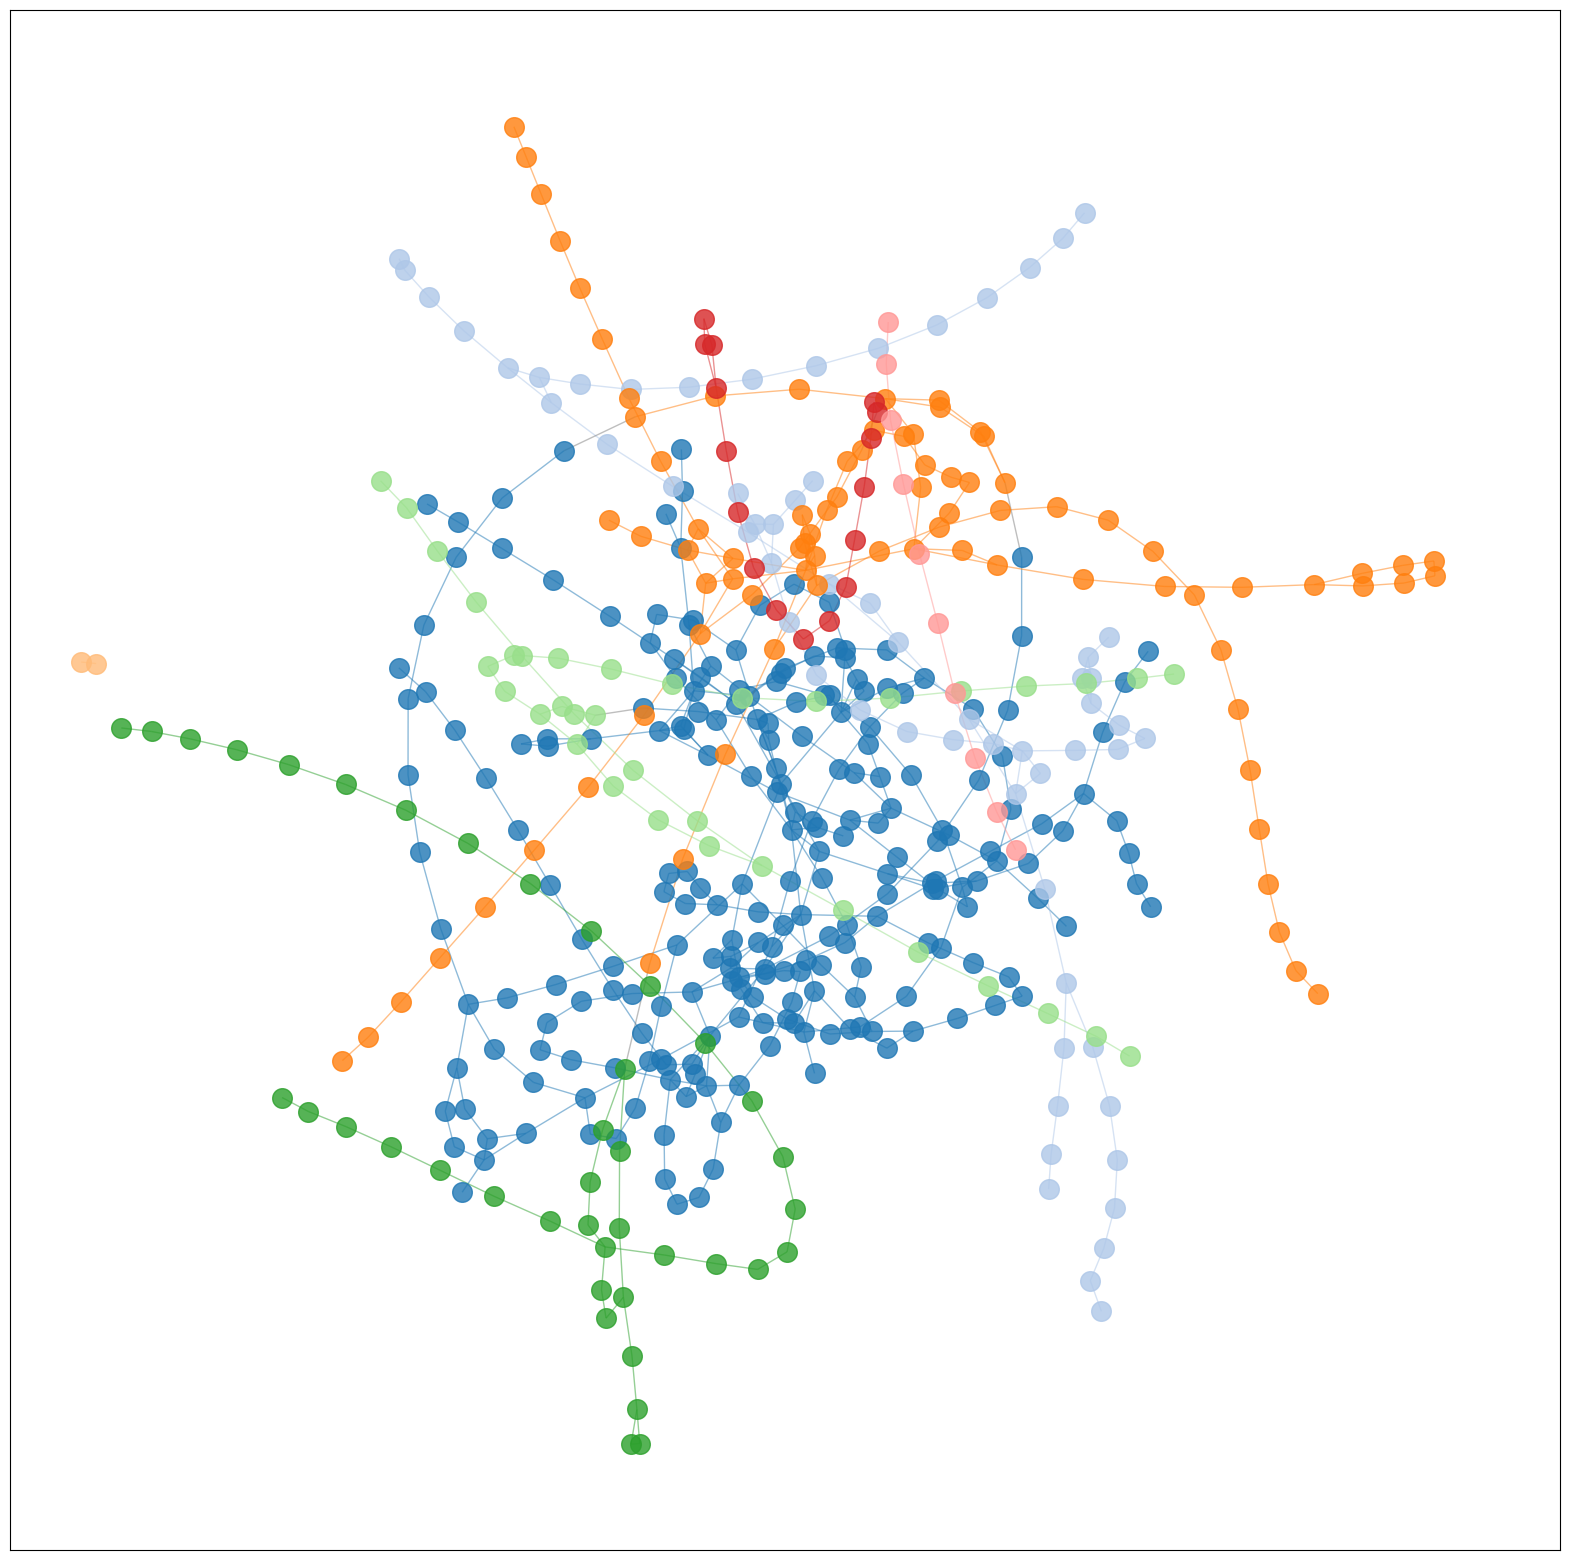

In [ ]:
# Consider clustering for a particular transport type (tram) in the city
city_G = city_networks[city_name.lower()]["tram"]
clusters_tram = spectral_clustering.fit_predict(city_G)
plot_clusters(city_G=city_G, city_node_clusters=clusters_tram, n_classes=8)